## ANOVA на практике

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                        MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# Загрузим первые данные

post_likes = pd.read_csv('post_likes.csv')

In [3]:
post_likes.head()

,id,button,likes
0,S001,red,160
1,S002,red,150
2,S003,red,150
3,S004,red,150
4,S005,red,187


Рисуем графики:

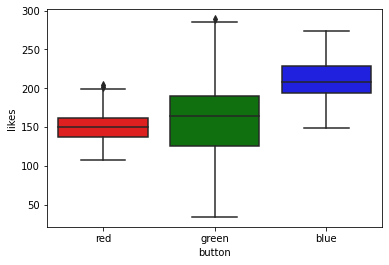

In [4]:
# боксплот

sns.boxplot(x='button', y='likes', data=post_likes, palette=['r', 'g', 'b'])

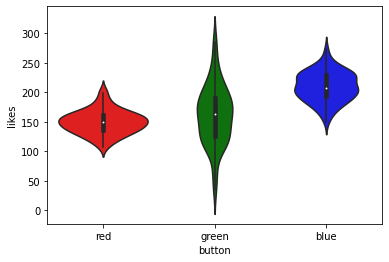

In [5]:
# скрипичный график

sns.violinplot(x='button', y='likes', data=post_likes, palette=['r', 'g', 'b'])

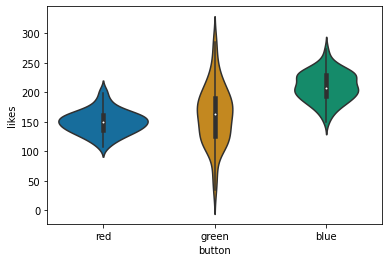

In [6]:
# скрипичный график для наблюдателей с цветовой слепотой

sns.violinplot(x='button', y='likes', data=post_likes, palette='colorblind')

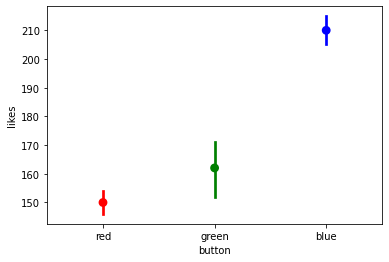

In [7]:
# средние с доверительными интервалами

sns.pointplot(x='button', y='likes', data=post_likes, palette=['r', 'g', 'b'])

Три способа посчитать однофакторый ANOVA

In [8]:
# через scipy

red = post_likes.query('button == "red"').likes
green = post_likes.query('button == "green"').likes
blue = post_likes.query('button == "blue"').likes

In [16]:
ss.f_oneway(red, green, blue)

F_onewayResult(statistic=85.99631112614011, pvalue=3.4370045810218544e-30)

In [17]:
# через statsmodels

model = smf.ols(formula = "likes ~ C(button)", data = post_likes).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(button),2.0,201960.286667,100980.143333,85.996311,3.437005e-30
Residual,297.0,348748.710000,1174.238081,NaN,NaN


In [18]:
# Через pingouin

pg.anova(data=post_likes, dv='likes', between='button')

,Source,ddof1,ddof2,F,p-unc,np2
0,button,2,297,85.996311,3.437005e-30,0.366728


In [12]:
# Вывод: группы действительно различаются между собой, отклоняем H0 о равенстве средних значений!

Тестируем нормальность:

In [21]:
# через scipy

print(ss.shapiro(red))
print(ss.shapiro(green))
print(ss.shapiro(blue))

ShapiroResult(statistic=0.988104522228241, pvalue=0.515945315361023)
ShapiroResult(statistic=0.9887180328369141, pvalue=0.5625539422035217)
ShapiroResult(statistic=0.9937936663627625, pvalue=0.9309920072555542)


In [22]:
# другой вариант

print(ss.normaltest(red))
print(ss.normaltest(green))
print(ss.normaltest(blue))

NormaltestResult(statistic=1.8343585907539965, pvalue=0.3996447324611219)
NormaltestResult(statistic=0.6727062715909409, pvalue=0.7143707913703767)
NormaltestResult(statistic=0.4606964500747045, pvalue=0.7942569741771747)


In [23]:
# Через pingouin

pg.normality(data=post_likes, dv='likes', group='button', method='normaltest')

,W,pval,normal
red,1.834359,0.399645,True
green,0.672706,0.714371,True
blue,0.460696,0.794257,True


In [24]:
# Через qq-графики

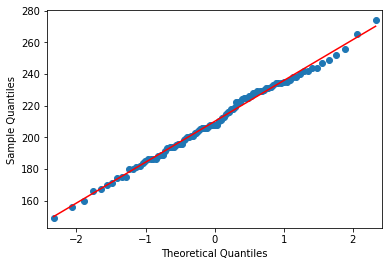

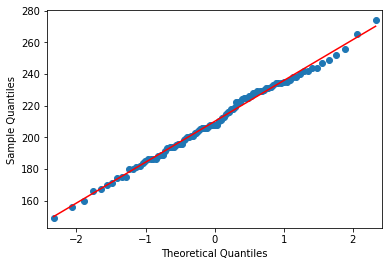

In [25]:
sm.qqplot(blue, line='r')

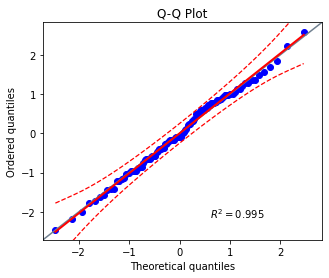

In [26]:
pg.qqplot(blue)

Тестируем различия в дисперсиях:

In [27]:
# через scipy

ss.levene(red, green, blue)

LeveneResult(statistic=35.214282435572876, pvalue=1.8886636651084242e-14)

In [28]:
# Через pingouin

pg.homoscedasticity(data=post_likes, dv='likes', group='button')

,W,pval,equal_var
levene,35.214282,1.888664e-14,False


In [29]:
# Поскольку дисперсии не равны, необходимо использовать поправку, например ANOVA Уэлча

In [30]:
# ANOVA Уэлча в pingouin

pg.welch_anova(data=post_likes, dv='likes', between='button')

,Source,ddof1,ddof2,F,p-unc,np2
0,button,2,182.958104,177.856578,1.255660e-43,0.366728


## Множественные сравнения

In [31]:
# попарные сравнения без поправки

pg.pairwise_ttests(data=post_likes, dv='likes', between='button')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,button,blue,green,False,True,8.591097,198.0,two-sided,2.561866e-15,2.025e+12,1.210357
1,button,blue,red,False,True,18.769214,198.0,two-sided,7.952330e-46,1.582e+42,2.644301
2,button,green,red,False,True,2.240189,198.0,two-sided,2.619001e-02,1.583,0.315609


In [32]:
2.619001e-02

0.02619001

In [38]:
# попарные сравнения с поправкой Бонферрони (В рамках этого метода нам нужно разделить уровень значимости на 
# количество попарных сравнений, и считать различия значимыми только в том случае, если p-значение меньше нового порога)

pg.pairwise_ttests(data=post_likes, dv='likes', between='button', padjust='bonf')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,button,blue,green,False,True,8.591097,198.0,two-sided,2.561866e-15,7.685599e-15,bonf,2.025e+12,1.210357
1,button,blue,red,False,True,18.769214,198.0,two-sided,7.952330e-46,2.385699e-45,bonf,1.582e+42,2.644301
2,button,green,red,False,True,2.240189,198.0,two-sided,2.619001e-02,7.857004e-02,bonf,1.583,0.315609


In [34]:
7.857004e-02

0.07857004

In [37]:
# Тест Тьюки (критерий Тьюки более консервативен, чем обычный t-критерий, 
# но гораздо менее консервативен по сравнению с поправкой Бонферрони)

pg.pairwise_tukey(data=post_likes, dv='likes', between='button')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,blue,green,210.03,162.02,48.01,4.846108,9.906919,0.001000,1.395736
1,blue,red,210.03,149.96,60.07,4.846108,12.395514,0.001000,1.746342
2,green,red,162.02,149.96,12.06,4.846108,2.488595,0.035581,0.350606


In [36]:
0.035581

0.035581

In [46]:
# Тест Геймс-Хоувелла (т.к. группы имеют разную дисперсию, то применяется критерий Геймса-Хоувелла)

pg.pairwise_gameshowell(data=post_likes, dv='likes', between='button')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,blue,green,210.03,162.02,48.01,5.588343,8.591097,145.583529,0.001000,1.210357
1,blue,red,210.03,149.96,60.07,3.200454,18.769214,188.902921,0.001000,2.644301
2,green,red,162.02,149.96,12.06,5.383475,2.240189,129.889834,0.068387,0.315609


In [39]:
0.068387

0.068387

In [40]:
# Через statsmodels

pairwise_tukeyhsd(post_likes.likes, post_likes.button).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
blue,green,-48.01,0.001,-59.4257,-36.5943,True
blue,red,-60.07,0.001,-71.4857,-48.6543,True
green,red,-12.06,0.0356,-23.4757,-0.6443,True


In [41]:
MultiComparison(post_likes.likes, post_likes.button).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
blue,green,-48.01,0.001,-59.4257,-36.5943,True
blue,red,-60.07,0.001,-71.4857,-48.6543,True
green,red,-12.06,0.0356,-23.4757,-0.6443,True


## Многофакторный ANOVA

In [37]:
ads_clicks = pd.read_csv('ads_clicks.csv')

In [38]:
ads_clicks

,id,ads,age_group,clicks
0,S001,classic,18-27,40
1,S002,classic,18-27,22
2,S003,classic,18-27,41
3,S004,classic,18-27,35
4,S005,classic,18-27,39
...,...,...,...,...
595,S596,bold,46 and more,3
596,S597,bold,46 and more,5
597,S598,bold,46 and more,6
598,S599,bold,46 and more,5


In [50]:
# через statsmodels, только главные эффекты

In [40]:
model_main = smf.ols('clicks ~ C(ads) + C(age_group)', data=ads_clicks).fit()
anova_lm(model_main)

,df,sum_sq,mean_sq,F,PR(>F)
C(ads),1.0,33735.001667,33735.001667,68.810244,7.245176e-16
C(age_group),2.0,400495.163333,200247.581667,408.450696,1.950084e-112
Residual,596.0,292195.753333,490.261331,NaN,NaN


In [45]:
# полученный результат не учитывает взаимодействие следущих факторов:

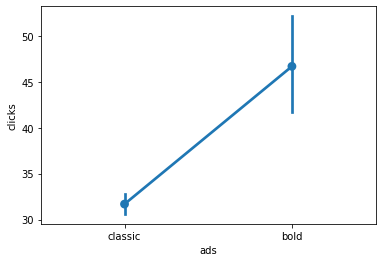

In [46]:
# первый фактор

sns.pointplot(data=ads_clicks, x='ads', y='clicks')

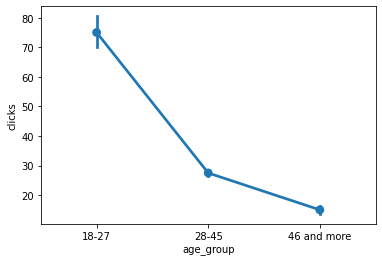

In [47]:
# второй фактор

sns.pointplot(data=ads_clicks, x='age_group', y='clicks')

In [48]:
# ВЗАИМОДЕЙСТВИЕ

model_intercat = smf.ols('clicks ~ C(ads) + C(age_group) + C(ads):C(age_group)', data=ads_clicks).fit()
anova_lm(model_intercat)

,df,sum_sq,mean_sq,F,PR(>F)
C(ads),1.0,33735.001667,33735.001667,336.722432,6.446773e-60
C(age_group),2.0,400495.163333,200247.581667,1998.750536,1.636934e-264
C(ads):C(age_group),2.0,232685.043333,116342.521667,1161.260853,5.618312e-206
Residual,594.0,59510.710000,100.186380,NaN,NaN


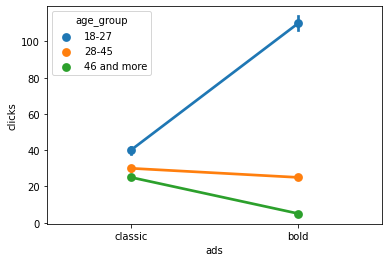

In [49]:
sns.pointplot(data=ads_clicks, x='ads', hue='age_group', y='clicks')

In [51]:
# через pingouin

In [52]:
pg.anova(data=ads_clicks, dv='clicks', between=['ads', 'age_group'])

,Source,SS,DF,MS,F,p-unc,np2
0,ads,33735.001667,1,33735.001667,336.722432,6.446773e-60,0.361786
1,age_group,400495.163333,2,200247.581667,1998.750536,1.636934e-264,0.870631
2,ads * age_group,232685.043333,2,116342.521667,1161.260853,5.618312e-206,0.796333
3,Residual,59510.710000,594,100.186380,NaN,NaN,NaN


In [53]:
# размер эффекта (n2 в сумме даст 100%, показывает насколько влияет каждая из групп)

pg.anova(data=ads_clicks, dv='clicks', between=['ads', 'age_group'], effsize='n2')

,Source,SS,DF,MS,F,p-unc,n2
0,ads,33735.001667,1,33735.001667,336.722432,6.446773e-60,0.046440
1,age_group,400495.163333,2,200247.581667,1998.750536,1.636934e-264,0.551323
2,ads * age_group,232685.043333,2,116342.521667,1161.260853,5.618312e-206,0.320315
3,Residual,59510.710000,594,100.186380,NaN,NaN,NaN


In [60]:
# тип суммы квадратов

pg.anova(data=ads_clicks, dv='clicks', between=['ads', 'age_group'], ss_type=3)

,Source,SS,DF,MS,F,p-unc,np2
0,ads,33735.001667,1,33735.001667,336.722432,6.446773e-60,0.361786
1,age_group,400495.163333,2,200247.581667,1998.750536,1.636934e-264,0.870631
2,ads * age_group,232685.043333,2,116342.521667,1161.260853,5.618312e-206,0.796333
3,Residual,59510.710000,594,100.186380,NaN,NaN,NaN


In [61]:
# для примера разбалансируем данные

In [62]:
dat_unbalance = ads_clicks.query('id != "S001"')

In [64]:
dat_unbalance.head()

,id,ads,age_group,clicks
1,S002,classic,18-27,22
2,S003,classic,18-27,41
3,S004,classic,18-27,35
4,S005,classic,18-27,39
5,S006,classic,18-27,35


In [67]:
# тип суммы квадратов

pg.anova(data=dat_unbalance, dv='clicks', between=['ads', 'age_group'], ss_type=1)

,Source,SS,DF,MS,F,p-unc,np2
0,ads,33803.779316,1.0,33803.779316,336.840901,6.486330e-60,0.362256
1,age_group,401187.127208,2.0,200593.563604,1998.833209,2.914479e-264,0.870825
2,ads * age_group,231923.625646,2.0,115961.812823,1155.512262,2.698570e-205,0.795801
3,Residual,59510.709899,593.0,100.355329,NaN,NaN,NaN


In [68]:
# меняем местами age_groups и ads

pg.anova(data=dat_unbalance, dv='clicks', between=['age_group', 'ads'], ss_type=1)

,Source,SS,DF,MS,F,p-unc,np2
0,age_group,401187.127208,2.0,200593.563604,1998.833209,2.914479e-264,0.870825
1,ads,33265.263676,1.0,33265.263676,331.474812,3.626438e-59,0.358555
2,age_group * ads,231923.625646,2.0,115961.812823,1155.512262,2.698570e-205,0.795801
3,Residual,59510.709899,593.0,100.355329,NaN,NaN,NaN


In [69]:
# теперь меняем тип ss_type 

pg.anova(data=dat_unbalance, dv='clicks', between=['age_group', 'ads'], ss_type=2)

,Source,SS,DF,MS,F,p-unc,np2
0,age_group,401187.127208,2.0,200593.563604,1998.833209,2.914479e-264,0.870825
1,ads,33265.263676,1.0,33265.263676,331.474812,3.626438e-59,0.358555
2,age_group * ads,231923.625646,2.0,115961.812823,1155.512262,2.698570e-205,0.795801
3,Residual,59510.709899,593.0,100.355329,NaN,NaN,NaN


In [70]:
# теперь меняем тип ss_type 

pg.anova(data=dat_unbalance, dv='clicks', between=['age_group', 'ads'], ss_type=3)

,Source,SS,DF,MS,F,p-unc,np2
0,age_group,399202.638264,2.0,199601.319132,1988.945896,1.048185e-263,0.870266
1,ads,33678.455412,1.0,33678.455412,335.592099,9.673077e-60,0.361399
2,age_group * ads,231923.625646,2.0,115961.812823,1155.512262,2.698570e-205,0.795801
3,Residual,59510.709899,593.0,100.355329,NaN,NaN,NaN
